## <center> SPACESHIP TITANIC 
### <center> DATA PREPARATION



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 15
%matplotlib inline

In [ ]:
from google.colab import files
upload = files.upload()

In [ ]:
train = pd.read_csv('train_transform.csv', index_col=False)
test = pd.read_csv('test_transform.csv', index_col= False)

print('Nunber of columns: {}, number of rows: {}\n'.format(train.shape[1], train.shape[0]))
print('Train features:\n', train.columns)

Nunber of columns: 21, number of rows: 8693

Train features:
 Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'GroupID', 'GroupSize', 'InPerson', 'CabinDeck',
       'CabinNumber', 'CabinSide', 'Surname'],
      dtype='object')


> ### 1. MISSING VALUES

> > #### 1.1. GENERAL

The first step I would like to do is filling in the missing values. As the EDA, the missing values for each feature take account for 2-2.5% of rows which is quite small.

However, if we take number of null values for each passerger, it is at approx 25% of travelers have at least 1 missing variable.

Also, we need to figure out whether there is a relationship of missing values and the targets.

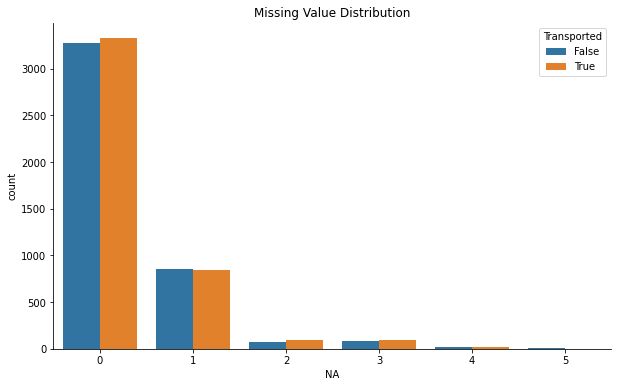

In [ ]:
### Plot the missing value distribution
NA_data = train.copy()
NA_data['NA'] = NA_data.isna().sum(axis = 1)

fig = plt.figure(figsize = (10, 6))
sns.countplot(data = NA_data, x = 'NA', hue = 'Transported')
sns.despine(bottom = False, left = False)
plt.title('Missing Value Distribution')

plt.show()

It seems that the number of missing values per passenger is indenpendent on the target.


<br>

The easiest way to deal with missing values is to just use the median for continuous features and the mode for categorical features. This will work 'well enough' but if we want to maximize the accuracy of the models, it is better to find out the same patterns of features, e.g. same family surname - same home planet, same group - same destination? Then choose the best estimated missing values.

In [ ]:
### Combine train set and test set to have a full dataset for the imputation

a = train.loc[:, ~train.columns.isin(['Transported'])]
df = pd.concat([a, test], ignore_index = True)

<br>
<br>

> > #### *1.2. HOMEPLANET*
> > > Same Group - Same Planet?

In [ ]:
### Joint distribution of Group and HomePlanet
group_home = df.groupby(['GroupID', 'HomePlanet']).size()  # Number of passengers have same groupID and same HomePlanet
group_home = group_home.unstack(level = -1)   #Return dataframe with columns of HomePlanet

group_home.head()

HomePlanet,Earth,Europa,Mars
GroupID,,,
1,NaN,1.0,NaN
2,1.0,NaN,NaN
3,NaN,2.0,NaN
4,1.0,NaN,NaN
5,1.0,NaN,NaN


In [ ]:
### Now, we will check every entry has value > 1, if sum(entry > 0, axis = 1) = 1, that means passengers in a group come from 
### a same home planet. Then it is easy to fill in the missing value.
### If that sum > 1, that means in a group, there are at least 2 passengers from 2 different home planets

print('Number of unique HomePlanet in a group: ')
(group_home > 0).sum(axis = 1).value_counts()

Number of unique HomePlanet in a group: 


1    9124
dtype: int64

GREAT! So every passenger comes from a same group will have a same home planet. 

Then, if a passenger travels in group, we can find out their HomePlanet missing values

In [ ]:
# group_homeplanet = group_homeplanet.stack().reset_index()

### Number of missing values 
home_NA = df['HomePlanet'].isna().sum()


### passengers have no homeplanet
home_index = df[df['HomePlanet'].isna()]

### passengers have no homeplanet but they travel with groups
home_index = home_index[home_index['GroupID'].isin(group_home.index)].index


### Filling corresponding missing values
df.loc[home_index, 'HomePlanet'] = df.iloc[home_index, :]['GroupID'].map(lambda x: group_home.idxmax(axis = 1)[x])


# Check the number of missing values before and after the imputation
print('Number of missing values in HomePlanet before filling based on GroupID: {}'.format(home_NA))
print('Number of missing value in HomePlanet after filling based on GroupID: {}'.format(df['HomePlanet'].isna().sum()))

Number of missing values in HomePlanet before filling based on GroupID: 288
Number of missing value in HomePlanet after filling based on GroupID: 157


<br>

> > > Same Cabin Deck - Same HomePlanet?

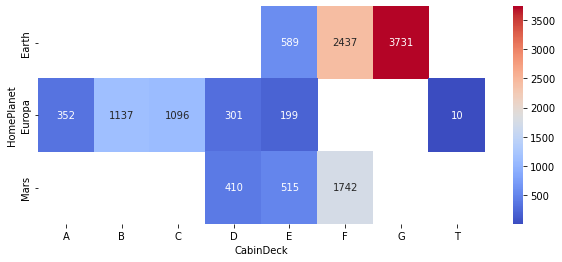

In [ ]:
### Joint-distribution of Cabin Deck and HomePlanet
cabin_home = df.copy()
cabin_home = cabin_home.groupby(['CabinDeck', 'HomePlanet']).size()
cabin_home = cabin_home.unstack()

## Heatmap of missing values
plt.figure(figsize = (10, 4))
sns.heatmap(data = cabin_home.T, annot = True, fmt = 'n', cmap = 'coolwarm')

*Insights*:
  - A, B, C, T: only Europa people
  - G: only Earth people
  - D, E, F: mixed


In [ ]:
### Passenger in A, B, C and T decks
cabin_index1 = df[(df['HomePlanet'].isna()) & ( df['CabinDeck'].isin(['A', 'B', 'C', 'T']))].index
df.loc[cabin_index1, 'HomePlanet'] = 'Europa'

### Passengers in G deck
cabin_index2 = df[(df['HomePlanet'].isna()) & ( df['CabinDeck']== 'G')].index
df.loc[cabin_index2, 'HomePlanet'] = 'Earth'

print('Number of missing values in HomePlanet after filling based on Cabin Deck: {}'.format(df['HomePlanet'].isna().sum()))

Number of missing values in HomePlanet after filling based on Cabin Deck: 94


<br>

> > > Same Surname - Same HomePlanet?

In [ ]:
name_home = df.copy().groupby(['Surname', 'HomePlanet'])['HomePlanet'].size()
name_home = name_home.unstack()

# How many homeplanet in a surname
print('Number of unique HomePlanets in a surname:')
(name_home > 0).sum(axis = 1).value_counts()

Number of unique HomePlanets in a surname:


1    2402
dtype: int64

WONDERFUL! All passengers sharing a surname come from the same HomePlanet

In [ ]:
surname_index = df[df['HomePlanet'].isna()]
surname_index = surname_index[surname_index['Surname'].isin(name_home.index)].index

df.loc[surname_index, 'HomePlanet'] = df.iloc[surname_index, :]['Surname'].map(lambda x: name_home.idxmax(axis = 1)[x])

print('Number of missing values in HomePlanet after filling based on Surname is {}'.format(df['HomePlanet'].isna().sum()))

Number of missing values in HomePlanet after filling based on Surname is 10


<br>

Great! Now there are only 10 missing values in HomePlanet. Let's take a look at 10 passengers

In [ ]:
df.loc[df['HomePlanet'].isna(), ['PassengerId', 'HomePlanet', 'Destination', 'CabinDeck']]

,PassengerId,HomePlanet,Destination,CabinDeck
2274,2443_01,NaN,TRAPPIST-1e,D
2631,2817_01,NaN,TRAPPIST-1e,F
3091,3331_01,NaN,TRAPPIST-1e,F
4548,4840_01,NaN,TRAPPIST-1e,F
5762,6108_01,NaN,TRAPPIST-1e,F
8969,0616_01,NaN,TRAPPIST-1e,E
10583,4052_01,NaN,TRAPPIST-1e,D
11913,7065_01,NaN,TRAPPIST-1e,E
12551,8435_01,NaN,TRAPPIST-1e,F
12725,8775_01,NaN,TRAPPIST-1e,D


Alright, It seems that they arrive in the same destination. Let's check the joint-distribution of HomePlanet and Destination

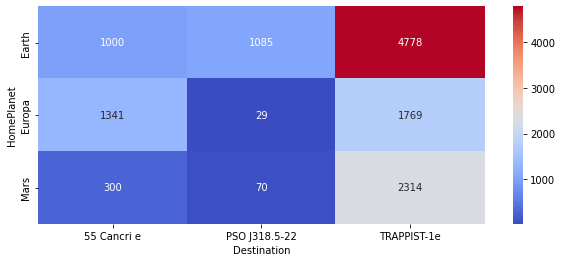

In [ ]:
dest_home = df.copy().groupby(['Destination', 'HomePlanet']).size()
dest_home = dest_home.unstack()

### Plot
plt.figure(figsize = (10, 4))
sns.heatmap(data = dest_home.T, cmap = 'coolwarm', annot = True, fmt = 'g')

<br>

Most people moving to TRAPPIST-1e are from the Earth. So we can replace the missing HomePlanet by 'Earth' for cabin deck E, F while passengers on deck D are from Mars. Because deck D has no passengers from the Earth as we did the analysis before

In [ ]:
### For passengers on deck E, F
dest_index1 = df[(df['HomePlanet'].isna()) & (df['CabinDeck'].isin(['E', 'F']))].index
df.loc[dest_index1, 'HomePlanet'] = 'Earth'

### For passengers on deck D
dest_index2 = df[(df['HomePlanet'].isna()) & (df['CabinDeck'] == 'D')].index
df.loc[dest_index2, 'HomePlanet'] = 'Mars'

print('The number of missing HomePlanet after filling based on destination is {}'.format(df['HomePlanet'].isna().sum()))

The number of missing HomePlanet after filling based on destination is 0


<br>

FANTASTIC! We have done with HomePlanet missing values

> > #### *1.3. DESTINATION*

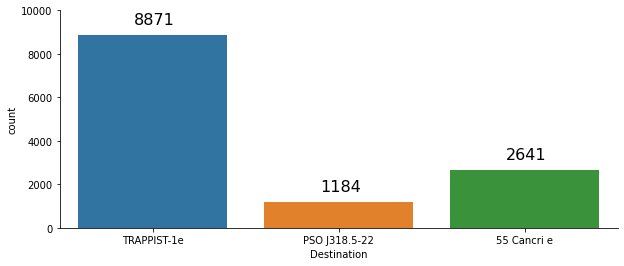

In [ ]:
### plot
plt.figure(figsize = (10, 4))
ax = sns.countplot(data = df, x = 'Destination')
sns.despine(bottom = False, left = False)
plt.ylim([0, 10000])
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height() + 500),size = 16)

2/3 passengers arrive to TRAPPIST-1e.

We will check the relationship of destination and groupID/surname/cabin. 

In [ ]:
### Check if all members in group have the same destination
print('Number of unique destinations in a group')
dest_group = df.copy().groupby(['GroupID', 'Destination']).size().unstack()
print((dest_group > 0).sum(axis = 1).value_counts())


### Check if all members in a family have the same destination
print('\nNumber of unique destinations in a family')
dest_name = df.copy().groupby(['Surname', 'Destination']).size().unstack()
print((dest_name > 0).sum(axis = 1).value_counts())


### Check if all passengers in a cabin deck have the same destination
print('\nNumber of unique destinations in a cabin deck')
dest_deck = df.copy().groupby(['CabinDeck', 'Destination']).size().unstack()
print((dest_deck > 0).sum(axis = 1).value_counts())

Number of unique destinations in a group
1    8056
2     997
3      73
dtype: int64

Number of unique destinations in a family
2    1194
1     766
3     442
dtype: int64

Number of unique destinations in a cabin deck
3    7
2    1
dtype: int64


It seems that the destination does not share unique patterns to GroupID, Surname and Cabin Deck. Thus, we will filling the destination NA values by its mode - TRAPPIST-1e

In [ ]:
df.loc[df[df['Destination'].isna()].index, 'Destination'] = 'TRAPPIST-1e'
print('Number of destination missing values is {}'.format(df['Destination'].isna().sum()))

Number of destination missing values is 0


> > #### 1.4. SURNAME

The reason we are filling missing surnames is because we will use surnames later to fill missing values of other features. It also means we can improve the accuracy of the family size feature.

> > > Same Group - Same Surname?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


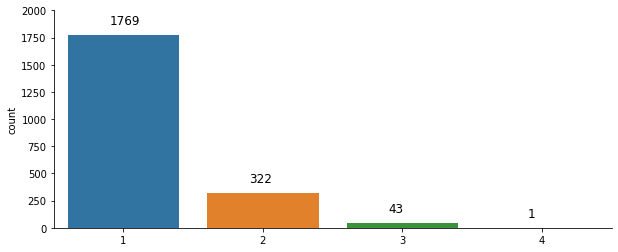

In [ ]:
### Joint distribution of GroupID and Surname
group_name = df[df['GroupSize'] > 1].groupby(['GroupID', 'Surname']).size().unstack()


plt.figure(figsize = (10, 4))
ax = sns.countplot((group_name > 0).sum(axis = 1))
sns.despine(bottom = False, left = False)
plt.ylim([0, 2000])
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+100),size = 12)
  # ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height() + 500),size = 16)



Majority of groups consist a surname. We can fill in the surname NA values by the most frequent surname in the group

In [ ]:
### Get passengers have no Surname but travel in group
surname_index = df[df['Surname'].isna()]
surname_index = surname_index[surname_index['GroupID'].isin(group_name.index)].index

### Filling surname missing values
df.loc[surname_index, 'Surname'] = df.iloc[surname_index, :]['GroupID'].map(lambda x: group_name.idxmax(axis = 1)[x])

print('Number of Surname missing values left is {}'.format(df['Surname'].isna().sum()))

Number of Surname missing values left is 155


> > #### *1.5. CABIN SIDE*

> > > Same Group - Same Cabin side?

[Text(0.5, 0, '# cabin sides'),
 Text(0.5, 1.0, 'Number of Unique Cabin Sides in a group')]

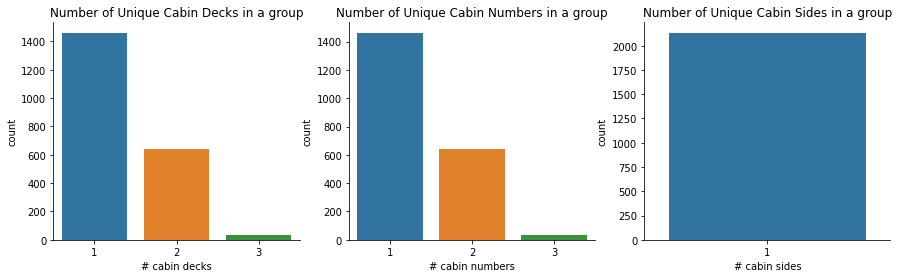

In [ ]:
### Joint Distribution of GroupID and Cabin deck
group_cabindeck = df[df['GroupSize'] > 1].groupby(['GroupID', 'CabinDeck']).size().unstack()
group_cabindeck['size'] = (group_cabindeck >0).sum(axis = 1)

### Joint Distribution of GroupID and Cabin number
group_cabinno = df[df['GroupSize'] > 1].groupby(['GroupID', 'CabinNumber']).size().unstack()
group_cabinno['size'] = (group_cabinno >0).sum(axis = 1)

### Joint Distribution of GroupID and Cabin side
group_side = df[df['GroupSize'] > 1].groupby(['GroupID', 'CabinSide']).size().unstack()
group_side['size'] = (group_side >0).sum(axis = 1)

### Plot
figures = plt.figure(figsize =(15, 4))

ax1 = figures.add_subplot(1, 3, 1)
sns.countplot(data = group_cabindeck, x = 'size')
sns.despine(bottom = False, left = False)
ax1.set(title = 'Number of Unique Cabin Decks in a group', xlabel ='# cabin decks')

ax2 = figures.add_subplot(1, 3, 2)
sns.countplot(data = group_cabinno, x = 'size')
sns.despine(bottom = False, left = False)
ax2.set(title = 'Number of Unique Cabin Numbers in a group', xlabel = '# cabin numbers')

ax3 = figures.add_subplot(1, 3, 3)
sns.countplot(data = group_side, x = 'size')
sns.despine(bottom = False, left = False)
ax3.set(title = 'Number of Unique Cabin Sides in a group', xlabel = '# cabin sides')

Only CabinSide depends on groupID, CabinNumber and CabinDecks have a fairly good but not perfect correlation with groupID.

Then we fill in the CabinSide missing values first.

In [ ]:
group_side.drop(columns = 'size', inplace =True)

### filling missing values based on groupID
cabinside_idx = df[df['CabinSide'].isna()]
cabinside_idx = cabinside_idx[cabinside_idx['GroupID'].isin(group_side.index)].index

df.loc[cabinside_idx, 'CabinSide'] = df.iloc[cabinside_idx, :]['GroupID'].map(lambda x: group_side.idxmax(axis = 1)[x])

print('Nunber of CabinSide missing values left is {}'.format(df['CabinSide'].isna().sum()))

Nunber of CabinSide missing values left is 162


> > > Same Surname - Same Cabin Side?

In [ ]:
### Joint distribution of surname and cabin side
name_side = df[df['GroupSize'] > 1].groupby(['Surname', 'CabinSide']).size().unstack()
name_side['size'] = (name_side>0).sum(axis = 1)

print('Number of families is in the same Cabin side: {0} ({1:.2f}%)'.format(len(name_side[name_side['size'] ==1]), 
                                                                        len(name_side[name_side['size'] == 1])/len(name_side)*100))


Number of families is in the same Cabin side: 1251 (76.70%)


This shows that most families tend to stay in the same cabin side.

In [ ]:
name_side.drop(columns = 'size', inplace = True)

### Fliing the missing values by the surnames
name_side_idx = df[df['CabinSide'].isna()]
name_side_idx = name_side_idx[name_side_idx['Surname'].isin(name_side.index)].index

df.loc[name_side_idx, 'CabinSide'] = df.iloc[name_side_idx, :]['Surname'].map(lambda x: name_side.idxmax(axis = 1)[x])

print('Number of CabinSide missing values left is {}'.format(df['CabinSide'].isna().sum()))

Number of CabinSide missing values left is 66


In [ ]:
### Let's check the Cabin Side distribution
df['CabinSide'].value_counts()

S    6504
P    6400
Name: CabinSide, dtype: int64

The remaining missing values are replaced with an outliers because the # side S and # side P is approximate.

In [ ]:
df.loc[df['CabinSide'].isna(), 'CabinSide'] = 'Z'

print('Number of CabinSide missing values left is {}'.format(df['CabinSide'].isna().sum()))

Number of CabinSide missing values left is 0


> > #### *1.6. CABIN DECK*

> > > Same Group - Same Deck?

As we plotted the joint distribution of GroupID and CabinDeck, groups are more likely (about 68.46%) to stay in the same deck on spaceship.

Thus, firsly we filling the CabinDeck missing values by the GroupID

In [ ]:
### Joint Distribution of GroupID and Cabin deck
group_cabindeck = df[df['GroupSize'] > 1].groupby(['GroupID', 'CabinDeck']).size().unstack()
group_cabindeck['size'] = (group_cabindeck >0).sum(axis = 1)

print('Number of groups are in 1 cabindeck: {} ({:.2f}%)'.format(len(group_cabindeck[group_cabindeck['size'] == 1]), 
                                                            len(group_cabindeck[group_cabindeck['size'] == 1])/ len(group_cabindeck)*100
                                                            ))

Number of groups are in 1 cabindeck: 1461 (68.46%)


In [ ]:
group_cabindeck.drop(columns = 'size', inplace = True)
### Pasengers travel in group but have no CabinDeck 
group_deck_idx = df[df['CabinDeck'].isna()]
group_deck_idx = group_deck_idx[group_deck_idx['GroupID'].isin(group_cabindeck.index)].index

### filling missing values
df.loc[group_deck_idx, 'CabinDeck'] = df.iloc[group_deck_idx, :]['GroupID'].map(lambda x: group_cabindeck.idxmax(axis = 1)[x])

print('Number of CabinDeck missing values left is {}'.format(df['CabinDeck'].isna().sum()))

Number of CabinDeck missing values left is 162


> > > Same HomePlanet - Same CabinDeck?

In [ ]:
home_deck = df.copy().groupby(['HomePlanet', 'CabinDeck']).size().unstack()
home_deck


CabinDeck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,NaN,NaN,NaN,NaN,601.0,2496.0,3821.0,NaN
Europa,361.0,1161.0,1122.0,309.0,204.0,NaN,NaN,11.0
Mars,NaN,NaN,NaN,421.0,529.0,1772.0,NaN,NaN


Well, it is quite complicated if we only join HomePlanet and CabinDeck. We will add more features to have more clearer views

In [ ]:
home_deck = df.copy().groupby(['HomePlanet', 'Destination', 'InPerson', 'CabinDeck']).size().unstack()
home_deck

CabinDeck                              A      B      C      D      E       F  \
HomePlanet Destination   InPerson                                              
Earth      55 Cancri e   0           NaN    NaN    NaN    NaN   20.0    90.0   
                         1           NaN    NaN    NaN    NaN   47.0   289.0   
           PSO J318.5-22 0           NaN    NaN    NaN    NaN   18.0    67.0   
                         1           NaN    NaN    NaN    NaN   25.0   262.0   
           TRAPPIST-1e   0           NaN    NaN    NaN    NaN  133.0   438.0   
                         1           NaN    NaN    NaN    NaN  358.0  1350.0   
Europa     55 Cancri e   0          96.0  377.0  313.0   59.0   35.0     NaN   
                         1          67.0  141.0  159.0   46.0   34.0     NaN   
           PSO J318.5-22 0           2.0    5.0   11.0    NaN    NaN     NaN   
                         1           NaN    NaN   10.0    NaN    NaN     NaN   
           TRAPPIST-1e   0         152.0  459.0  428.0  120.0   53.0     NaN   
                         1          44.0  179.0  201.0   84.0   82.0     NaN   
Mars       55 Cancri e   0           NaN    NaN    NaN   32.0   15.0   104.0   
                         1           NaN    NaN    NaN   40.0   16.0    92.0   
           PSO J318.5-22 0           NaN    NaN    NaN    8.0    9.0    14.0   
                         1           NaN    NaN    NaN    9.0    7.0    21.0   
           TRAPPIST-1e   0           NaN    NaN    NaN  168.0  219.0   798.0   
                         1           NaN    NaN    NaN  164.0  263.0   743.0   

CabinDeck                               G    T  
HomePlanet Destination   InPerson               
Earth      55 Cancri e   0          272.0  NaN  
                         1          269.0  NaN  
           PSO J318.5-22 0          230.0  NaN  
                         1          466.0  NaN  
           TRAPPIST-1e   0         1075.0  NaN  
                         1         1509.0  NaN  
Europa     55 Cancri e   0            NaN  2.0  
                         1            NaN  NaN  
           PSO J318.5-22 0            NaN  NaN  
                         1            NaN  NaN  
           TRAPPIST-1e   0            NaN  1.0  
                         1            NaN  8.0  
Mars       55 Cancri e   0            NaN  NaN  
                         1            NaN  NaN  
           PSO J318.5-22 0            NaN  NaN  
                         1            NaN  NaN  
           TRAPPIST-1e   0            NaN  NaN  
                         1            NaN  NaN

It is not that perfect but it is more detailed. For example, passengers traveling from 'Earth' to '55 Cancri e' in group are more likely in deck G while travelings in person are more likely in deck F. Thus, we can use the mode to filling the CabinDeck missing values

In [ ]:
home_deck_idx = df[df['CabinDeck'].isna()].index

### Because pd.groupby has no index, we will use transform function to filling the missing values
deck_mode = df.copy().groupby(['HomePlanet', 'Destination', 'InPerson'])['CabinDeck'].transform(func = lambda x: x.fillna(pd.Series.mode(x)[0]))
df.loc[home_deck_idx, 'CabinDeck'] = deck_mode[home_deck_idx]

print('Number of CabinDeck missing values left is {}'.format(df['CabinDeck'].isna().sum()))

Number of CabinDeck missing values left is 0


> > #### *1.7. CABIN NUMBER*

> > > Cabin Number and GroupID

Let's take a scatter plot to figure out whether there is a relationship of CabinNumber and GroupID by CabinDeck

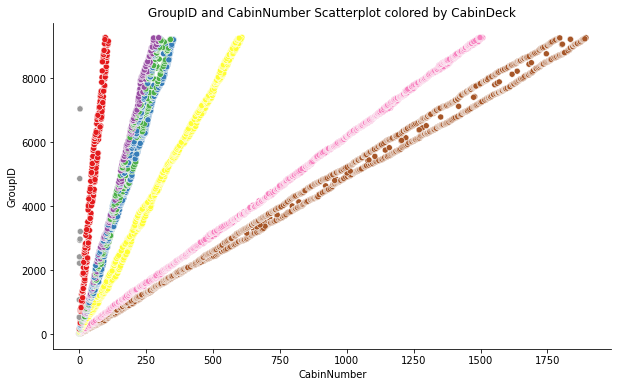

In [ ]:
fig = plt.figure(figsize = (10, 6))

### Color based on CabinDeck
from sklearn.preprocessing import LabelEncoder
color = LabelEncoder().fit_transform(df.loc[~df['CabinNumber'].isna(), 'CabinDeck'])
sns.scatterplot(data = df, y = 'GroupID', x = 'CabinNumber', c = color, cmap = 'Set1')
sns.despine(bottom = False, left = False)
plt.title('GroupID and CabinNumber Scatterplot colored by CabinDeck')
plt.show()

The CabinNumber and GroupID share a linear relationship on a CabinDeck. We can therefore extrapolate the missing cabin numbers using linear regression on a CabinDeck to get an approximate CabinNumber.

In [ ]:
from sklearn.linear_model import LinearRegression

### Because deck T is an outlier, we exclude it in the linear regression.
decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

for deck in decks:

  ### Determine training set and test set
  X_train = df.loc[~(df['CabinNumber'].isna()) & (df['CabinDeck'] == deck), 'GroupID']
  y_train = df.loc[~(df['CabinNumber'].isna()) & (df['CabinDeck'] == deck), 'CabinNumber']

  X_test = df.loc[(df['CabinNumber'].isna()) & (df['CabinDeck'] == deck), 'GroupID']

  ### Linear Regression
  reg = LinearRegression().fit(X_train.values.reshape(-1, 1), y_train)
  pred = reg.predict(X_test.values.reshape(-1, 1))

  ### Filling missing values
  df.loc[(df['CabinNumber'].isna()) & (df['CabinDeck'] == deck), 'CabinNumber'] = pred.astype(int)

print('Number of CabinNumber missing values left is {}'.format(df['CabinNumber'].isna().sum()))

Number of CabinNumber missing values left is 0


In [ ]:
### Seperate CabinNumber into chunks of 300 numbers
df.loc[df['CabinNumber'] <300,'CabinRegion'] = 1
df.loc[(df['CabinNumber'] >=300) & (df['CabinNumber'] <600),'CabinRegion'] = 2
df.loc[(df['CabinNumber'] >=600) & (df['CabinNumber'] <900),'CabinRegion'] = 3
df.loc[(df['CabinNumber'] >=900) & (df['CabinNumber'] <1200),'CabinRegion'] = 4
df.loc[(df['CabinNumber'] >=1200) & (df['CabinNumber'] <1500),'CabinRegion'] = 5
df.loc[(df['CabinNumber'] >=1500) & (df['CabinNumber'] <1800),'CabinRegion'] = 6
df.loc[(df['CabinNumber'] >=1800),'CabinRegion'] = 7


> > #### *1.8. VIP*

VIP is highly unbalance, so we just add the missing values by the mode

In [ ]:
df['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [ ]:
df['VIP'].fillna('False', inplace = True)

print('Number of VIP missing values left is {}'.format(df['VIP'].isna().sum()))

Number of VIP missing values left is 0


> > #### *1.9. CRYOSLEEP*

In order to impute the cryosleeping, we first should check the Expenditure features ('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'). Because, obviously those who stay in cryosleep cannot pay for any extra services in the spaceship.

In [ ]:
extra_services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['ExtraServices'] = df[extra_services].sum(axis = 1)
df['Expenditure'] = (df['ExtraServices'] != 0).astype(int)

In [ ]:
### Joint distribution of Cryosleep and Expenditure
df.groupby(['CryoSleep', 'Expenditure']).size().unstack()

Expenditure,0,1
CryoSleep,,
False,740.0,7339.0
True,4581.0,NaN


In [ ]:
### Filling the missing values
cryosleep_idx = df[df['CryoSleep'].isna()].index
cryosleep_mode = df.groupby('Expenditure')['CryoSleep'].transform(func = lambda x: x.fillna(pd.Series.mode(x)[0]))
df.loc[cryosleep_idx, 'CryoSleep'] = cryosleep_mode[cryosleep_idx]

print('Number of CryoSleep missing values left is {}'.format(df['CryoSleep'].isna().sum()))

Number of CryoSleep missing values left is 0


> > #### *1.10. AGE*

Age might depends on various features such as HomePlanet, InPerson, Expenditure, CabinDeck, etc. Thus, we try to add the missing values based on these hints

In [ ]:
df.groupby(['HomePlanet', 'Expenditure','InPerson', 'CabinDeck'])['Age'].median().unstack()

CabinDeck                           A     B     C     D     E     F     G  \
HomePlanet Expenditure InPerson                                             
Earth      0           0          NaN   NaN   NaN   NaN   7.0  16.0   8.0   
                       1          NaN   NaN   NaN   NaN  21.0  21.5  23.0   
           1           0          NaN   NaN   NaN   NaN  24.0  25.0  28.0   
                       1          NaN   NaN   NaN   NaN  25.0  24.0  26.0   
Europa     0           0         30.0  27.0  28.5  27.0  28.0   NaN   NaN   
                       1         37.5  34.0  35.0  31.0  33.0   NaN   NaN   
           1           0         35.0  34.0  33.0  33.0  34.0   NaN   NaN   
                       1         35.0  36.0  35.5  34.0  35.0   NaN   NaN   
Mars       0           0          NaN   NaN   NaN  29.5  26.0  18.0   NaN   
                       1          NaN   NaN   NaN  33.0  30.0  29.5   NaN   
           1           0          NaN   NaN   NaN  30.0  29.0  29.0   NaN   
                       1          NaN   NaN   NaN  31.0  28.5  30.0   NaN   

CabinDeck                           T  
HomePlanet Expenditure InPerson        
Earth      0           0          NaN  
                       1          NaN  
           1           0          NaN  
                       1          NaN  
Europa     0           0          NaN  
                       1          NaN  
           1           0         44.0  
                       1         35.0  
Mars       0           0          NaN  
                       1          NaN  
           1           0          NaN  
                       1          NaN

In [ ]:
### Filling the missing values
age_idx = df[df['Age'].isna()].index
age_median = df.groupby(['HomePlanet', 'Expenditure','InPerson', 'CabinDeck'])['Age'].transform(lambda x: x.fillna(x.median()))
df.loc[age_idx, 'Age'] = age_median[age_idx]

print('Number of Age missing values left is {}'.format(df['Age'].isna().sum()))

Number of Age missing values left is 0


In [ ]:
### Seperate ages into 5 big groups
df.loc[df['Age'] <= 12, 'AgeGroup'] = '0-12'
df.loc[(df['Age'] > 12) & (df['Age'] < 18), 'AgeGroup'] = '12-17'
df.loc[(df['Age'] >= 18) & (df['Age'] < 30), 'AgeGroup'] = '18-30'
df.loc[(df['Age'] >= 30) & (df['Age'] < 50), 'AgeGroup'] = '30-50'
df.loc[df['Age'] >= 50, 'AgeGroup'] = '50+'

> > #### *1.11. EXPENDITURE*

> > > Expenditure and CryoSleep

As we said, those who choose CryoSleep will not spend on any services

In [ ]:
for service in extra_services:
  df.loc[(df[service].isna()) & (df['CryoSleep'] == True), service] = 0

print('Number of extra services missing values is {}'.format(df[extra_services].isna().sum().sum()))

Number of extra services missing values is 866


> > > Expenditure and other features

Expenditure varies across many features but we will only impute missing values using HomePlanet, InPerson and Age group to prevent overfitting. We will also use the mean instead of the median because a large proportion of passengers don't spend anything and median usually comes out as 0. Note how under 12's don't spend anything.

In [ ]:
df.groupby(['HomePlanet', 'InPerson', 'AgeGroup'])['ExtraServices'].mean().unstack()

AgeGroup             0-12        12-17        18-30        30-50          50+
HomePlanet InPerson                                                          
Earth      0          0.0   724.902222   794.461431   761.139583   709.716535
           1          0.0   693.014898   780.113036   803.610451   810.024590
Europa     0          0.0  1153.160256  3133.115282  3947.082022  3398.630350
           1          NaN     0.000000  3206.810127  4006.734242  3861.372781
Mars       0          0.0  1176.839286  1189.869141  1140.086420  1360.907563
           1          0.0  1687.261538  1102.793443  1109.956044  1038.463087

In [ ]:
for service in extra_services:
  idx = df[df[service].isna()].index
  service_mean = df.groupby(['HomePlanet', 'InPerson', 'AgeGroup'])[service].transform(lambda x: x.fillna(x.mean()))
  df.loc[idx, service] = service_mean[idx]

print('Number of expenditure missing values is {}'.format(df[extra_services].isna().sum().sum()))

Number of expenditure missing values is 0


In [ ]:
### Update ExtraServices and Expenditure
df['ExtraServices'] = df[extra_services].sum(axis = 1)
df['Expenditure'] = (df['ExtraServices'] != 0).astype(int)

<br>
<br>
---------------------------------------------------

We finish imputing data. Let's look at again our data

In [ ]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupID',
       'GroupSize', 'InPerson', 'CabinDeck', 'CabinNumber', 'CabinSide',
       'ExtraServices', 'Expenditure', 'AgeGroup', 'CabinRegion'],
      dtype='object')

In [ ]:
df.drop(columns = ['Surname', 'Cabin', 'Name'], inplace = True)
df.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
                ..
CabinSide        0
ExtraServices    0
Expenditure      0
AgeGroup         0
CabinRegion      0
Length: 21, dtype: int64

**No missing values left!** It was a lot of effort but it should improve the accuracy of our models.

In [ ]:
df.to_csv()
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>